<a href="https://colab.research.google.com/github/AtfastrSlushyMaker/pl-standings-prediction-project/blob/main/notebooks/algorithms/svm/svm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

## Load and Inspect Dataset



✅ Dataset loaded from: ..\..\..\data\processed\team_season_aggregated.csv

🔍 Dataset Shape: (500, 35)
📅 Seasons Available: ['2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24', '2024-25']

📌 First rows preview:


,Season,Season_encoded,Team,Matches_Played,Home_Matches,Away_Matches,Wins,Draws,Losses,Home_Wins,...,Yellow_Cards,Red_Cards,Fouls,Corners,Avg_Corners,Win_Rate,Home_Win_Rate,Away_Win_Rate,Final_Position,Team_encoded
0,2000-01,0,Man United,38,19,19,24,8,6,15,...,44.0,3.0,433.0,269.0,7.078947,0.631579,0.789474,0.473684,1,27
1,2000-01,0,Arsenal,38,19,19,20,10,8,15,...,48.0,3.0,495.0,295.0,7.763158,0.526316,0.789474,0.263158,2,0
2,2000-01,0,Liverpool,38,19,19,20,9,9,13,...,50.0,4.0,473.0,243.0,6.394737,0.526316,0.684211,0.368421,3,24
3,2000-01,0,Leeds,38,19,19,20,8,10,11,...,72.0,3.0,589.0,270.0,7.105263,0.526316,0.578947,0.473684,4,22
4,2000-01,0,Ipswich,38,19,19,20,6,12,11,...,31.0,2.0,414.0,206.0,5.421053,0.526316,0.578947,0.473684,5,21


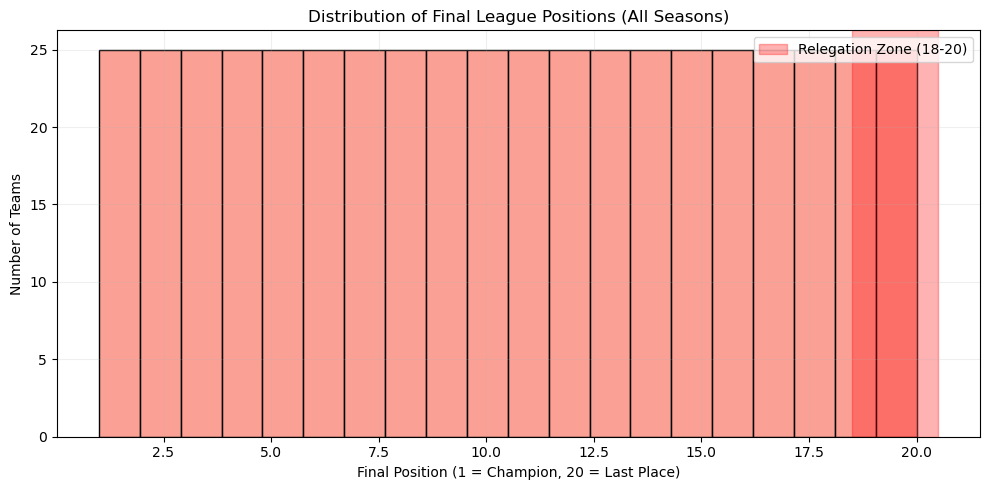


📉 Relegation Rate Across Dataset: 15.00% of teams finished in bottom 3


In [56]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Try to load the dataset from multiple fallback locations
dataset_paths = [
    Path('team_season_aggregated.csv'),
    Path('/content/team_season_aggregated.csv'),
    Path('/mnt/data/team_season_aggregated.csv'),
    Path('data/team_season_aggregated.csv'),
    Path('../../../data/processed/team_season_aggregated.csv'),
]

for path in dataset_paths:
    try:
        df_agg = pd.read_csv(path)
        print(f"✅ Dataset loaded from: {path}")
        break
    except FileNotFoundError:
        continue
else:
    raise FileNotFoundError("❌ team_season_aggregated.csv not found in any predefined paths.")

# 🕵️‍♂️ Inspect dataset dimensions and basic metadata
print(f"\n🔍 Dataset Shape: {df_agg.shape}")
print(f"📅 Seasons Available: {sorted(df_agg['Season'].unique()) if 'Season' in df_agg.columns else 'Not available'}")
print("\n📌 First rows preview:")
display(df_agg.head())

# 📉 Visualize distribution of Final Position for Relegation Risk
if 'Final_Position' in df_agg.columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(df_agg['Final_Position'], bins=20, kde=False, color='salmon')
    plt.axvspan(18.5, 20.5, color='red', alpha=0.3, label='Relegation Zone (18-20)')
    plt.title("Distribution of Final League Positions (All Seasons)")
    plt.xlabel("Final Position (1 = Champion, 20 = Last Place)")
    plt.ylabel("Number of Teams")
    plt.legend()
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

    relegation_rate = (df_agg['Final_Position'] >= 18).mean() * 100
    print(f"\n📉 Relegation Rate Across Dataset: {relegation_rate:.2f}% of teams finished in bottom 3")
else:
    print("⚠️ 'Final_Position' column not found in dataset.")


## Train-Test Split
Relegation-Aware Feature and Target Preparation for SVM



In [57]:
# ✅ Define predictive features (focused on end-of-season performance)
feature_cols = [
    'Points_Per_Game', 'Win_Rate', 'Goal_Difference',
    'Goals_Scored', 'Goals_Conceded',
    'Clean_Sheets', 'Shot_Accuracy',
    'Home_Win_Rate', 'Away_Win_Rate',
    'Yellow_Cards', 'Red_Cards',
    'Season_encoded', 'Team_encoded'
]

# 🔍 Confirm features exist in the dataset
available_features = [col for col in feature_cols if col in df_agg.columns]
missing_features = [col for col in feature_cols if col not in df_agg.columns]

if missing_features:
    print(f"⚠️ Missing features: {missing_features}")
else:
    print(f"✅ {len(available_features)} features validated for SVM.")

# 🎯 Target: Final league position (will later be categorized for relegation focus)
target_col = 'Final_Position'

# ⏳ Hold out latest season (2024-25) for evaluation
train_seasons = df_agg[df_agg['Season'] != '2024-25']
test_season  = df_agg[df_agg['Season'] ==  '2024-25']

# ✅ Split features and targets
X_train = train_seasons[available_features].copy()
y_train = train_seasons[target_col].copy()

X_test  = test_season[available_features].copy()
y_test  = test_season[target_col].copy()

# 📈 Print summary
print("\n📊 Relegation-Oriented Split Completed")
print(f"Training Set: {X_train.shape} | Test Set: {X_test.shape}")


✅ 13 features validated for SVM.

📊 Relegation-Oriented Split Completed
Training Set: (480, 13) | Test Set: (20, 13)


## SVM Regression — Base Model Training and Evaluation

Objective: Train a base SVM model and evaluate both general performance and relegation-specific prediction accuracy.

In [58]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 📈 Step 1: Create Base SVM Pipeline (Standard Scaling + SVR)
svm_pipeline = make_pipeline(
    StandardScaler(),
    SVR(kernel='rbf', C=10, epsilon=0.2)  # fixed hyperparameters
)

# 🚀 Step 2: Train the Base Model
svm_pipeline.fit(X_train, y_train)

# 🔍 Step 3: Predict on Both Sets
y_pred_train = svm_pipeline.predict(X_train)
y_pred_test = svm_pipeline.predict(X_test)

# 📊 Step 4: Global Performance Evaluation (Train/Test)
def evaluate(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{label} MAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.4f}")

print("📊 Performance Summary:")
evaluate(y_train, y_pred_train, label="Train")
evaluate(y_test, y_pred_test, label="Test")


📊 Performance Summary:
Train MAE: 0.549 | RMSE: 0.823 | R²: 0.9796
Test MAE: 0.975 | RMSE: 1.350 | R²: 0.9452


## Relegation-Specific Diagnostic
Objective: Quantify prediction accuracy for teams in the relegation zone (positions 18–20).

In [59]:
# 🎯 Focus: Teams at Risk of Relegation (Actual Position ≥ 18)
relegation_mask = y_test >= 18

if np.any(relegation_mask):
    rel_mae = mean_absolute_error(y_test[relegation_mask], y_pred_test[relegation_mask])
    rel_r2 = r2_score(y_test[relegation_mask], y_pred_test[relegation_mask])
    print("\n🚨 Relegation Risk Performance:")
    print(f"🔹 MAE on Relegation Teams: {rel_mae:.3f}")
    print(f"🔹 R² on Relegation Teams:  {rel_r2:.4f}")
else:
    print("\n⚠️ No relegation-risk teams found in the test set.")



🚨 Relegation Risk Performance:
🔹 MAE on Relegation Teams: 0.386
🔹 R² on Relegation Teams:  0.6570


## SVM Regressor Hyperparameter Tuning for Relegation Risk



In [60]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, ParameterGrid
import numpy as np
import time

# 🎯 Step 1: Define Weights — Emphasize Teams in Relegation Zone (positions ≥18)
weights = np.where(y_train >= 18, 2.0, 1.0)  # double weight for critical teams

# 🛠️ Step 2: Define Balanced Hyperparameter Grid (Moderate Range)
efficient_param_grid = [
    {'kernel': ['linear'], 'C': [1, 10], 'epsilon': [0.1, 0.2]},
    {'kernel': ['rbf'], 'C': [1, 10], 'gamma': ['scale'], 'epsilon': [0.1, 0.2]},
    {'kernel': ['poly'], 'C': [1], 'degree': [2, 3], 'gamma': ['scale'], 'epsilon': [0.1]}
]

# 📊 Step 3: Grid Summary
grid_list = list(ParameterGrid(efficient_param_grid))
n_combinations = len(grid_list)
cv = 3
print("="*70)
print("🔎 Efficient SVM Tuning — Balanced Mode (Relegation-Aware)")
print("="*70)
print(f"🔧 Grid Size: {n_combinations} combinations × {cv} folds = {n_combinations * cv} fits")
estimated = n_combinations * cv * 0.5
print(f"⏳ Estimated Runtime: ~{estimated:.0f} sec (~{estimated/60:.1f} min)")

# 🚀 Step 4: Launch Grid Search with Relegation Weights
start = time.time()
grid_search = GridSearchCV(
    estimator=SVR(),
    param_grid=efficient_param_grid,
    scoring='neg_mean_absolute_error',
    cv=cv,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train, sample_weight=weights)
end = time.time()

# ✅ Step 5: Report Results
print("\n✅ Grid Search Completed")
print(f"⏱️ Elapsed Time: {end - start:.2f} seconds")
print(f"🏆 Best Parameters: {grid_search.best_params_}")
print(f"🥇 Best Cross-Validated MAE: {-grid_search.best_score_:.4f}")

# 💾 Step 6: Save the Best Model for Deployment
best_svr_model = grid_search.best_estimator_
print("💾 Best model saved as 'best_svr_model'")


🔎 Efficient SVM Tuning — Balanced Mode (Relegation-Aware)
🔧 Grid Size: 10 combinations × 3 folds = 30 fits
⏳ Estimated Runtime: ~15 sec (~0.2 min)
Fitting 3 folds for each of 10 candidates, totalling 30 fits

✅ Grid Search Completed
⏱️ Elapsed Time: 9.13 seconds
🏆 Best Parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'linear'}
🥇 Best Cross-Validated MAE: 1.5261
💾 Best model saved as 'best_svr_model'

✅ Grid Search Completed
⏱️ Elapsed Time: 9.13 seconds
🏆 Best Parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'linear'}
🥇 Best Cross-Validated MAE: 1.5261
💾 Best model saved as 'best_svr_model'


## Evaluation of SVM Model: Relegation-Focused Analysis
1. Visual Comparison: Actual vs Predicted Final Positions
2. Model Metrics Summary Table: Base vs Optimized SVM
3. Relegation-Sensitive Metrics and Diagnostic Summary


## Visual Comparison of Predicted vs Actual Rankings


C:\Users\Mega Pc\AppData\Local\Temp\ipykernel_38592\202195282.py:18: UserWarning: Glyph 9917 (\N{SOCCER BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Mega Pc\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9917 (\N{SOCCER BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


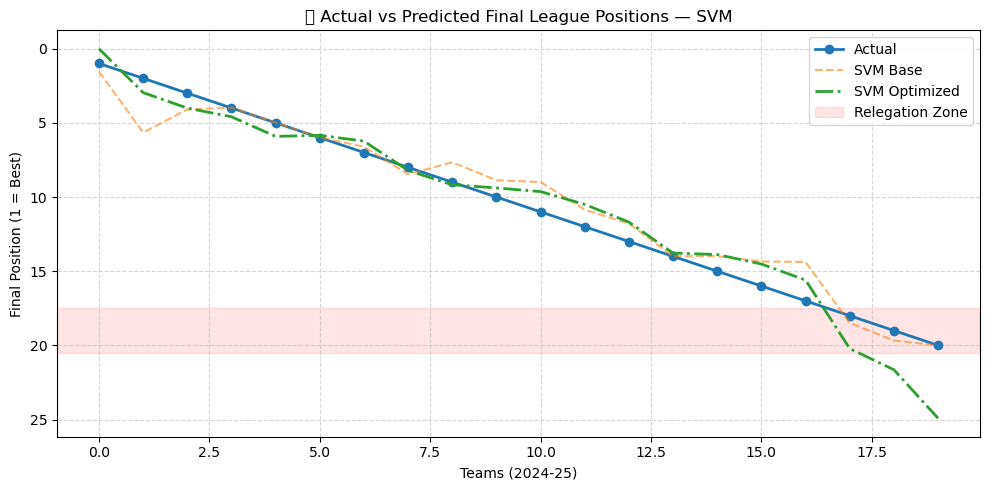

In [61]:
# Visualize true vs predicted positions with relegation zone emphasis
import matplotlib.pyplot as plt

# Generate predictions from optimized model
y_pred_best_svr = best_svr_model.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Actual", marker='o', linewidth=2)
plt.plot(y_pred_test, label="SVM Base", linestyle='--', alpha=0.6)
plt.plot(y_pred_best_svr, label="SVM Optimized", linestyle='-.', linewidth=2)
plt.axhspan(17.5, 20.5, color='red', alpha=0.1, label='Relegation Zone')
plt.title("⚽ Actual vs Predicted Final League Positions — SVM")
plt.xlabel("Teams (2024-25)")
plt.ylabel("Final Position (1 = Best)")
plt.gca().invert_yaxis()
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Model Metrics — Base vs Optimized SVM

In [62]:
# Compare performance of base and tuned SVM models
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae_base_test = mean_absolute_error(y_test, y_pred_test)
rmse_base_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_base_test = r2_score(y_test, y_pred_test)

mae_opt = mean_absolute_error(y_test, y_pred_best_svr)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_best_svr))
r2_opt = r2_score(y_test, y_pred_best_svr)

print("\n📋 Model Performance Summary:")
print(f"{'Model':<20} {'MAE':<10} {'RMSE':<10} {'R²':<10}")
print(f"{'SVM Base':<20} {mae_base_test:<10.3f} {rmse_base_test:<10.3f} {r2_base_test:<10.4f}")
print(f"{'SVM Optimized':<20} {mae_opt:<10.3f} {rmse_opt:<10.3f} {r2_opt:<10.4f}")



📋 Model Performance Summary:
Model                MAE        RMSE       R²        
SVM Base             0.975      1.350      0.9452    
SVM Optimized        1.228      1.620      0.9211    


## Relegation-Focused Visual Diagnostics — Optimized SVM


C:\Users\Mega Pc\AppData\Local\Temp\ipykernel_38592\1879443214.py:39: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Mega Pc\AppData\Local\Temp\ipykernel_38592\1879443214.py:39: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Mega Pc\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Mega Pc\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Mega Pc\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(

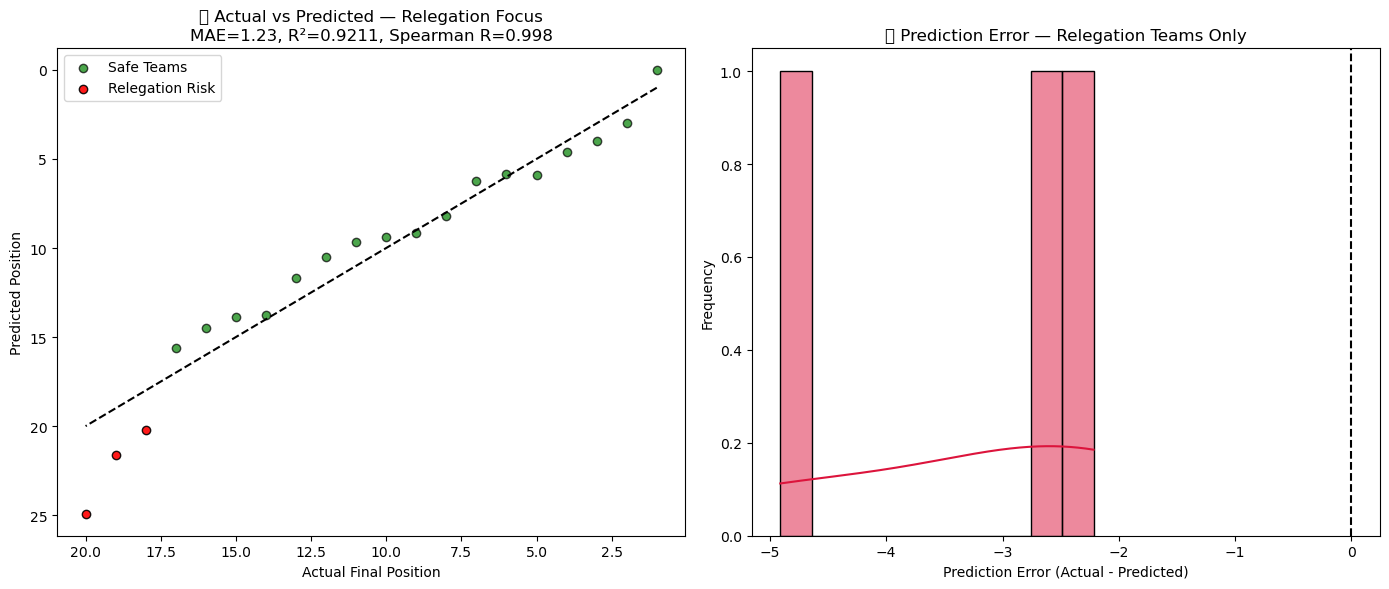

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import spearmanr

# 📊 Compute predictions and errors
y_pred_train_svr = best_svr_model.predict(X_train)
errors_train = y_train - y_pred_train_svr
errors_test = y_test - y_pred_best_svr

# 📉 Spearman correlation for ranking relevance
rank_corr = spearmanr(y_test, y_pred_best_svr).correlation

# 📍 Identify relegation teams (actual or predicted)
relegation_zone = (y_test >= 18) | (y_pred_best_svr >= 18)

# 🎨 Create visual comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

## 🔵 Actual vs Predicted (Highlight Relegation Zone)
axes[0].scatter(y_test[~relegation_zone], y_pred_best_svr[~relegation_zone],
                color='green', label='Safe Teams', edgecolors='k', alpha=0.7)
axes[0].scatter(y_test[relegation_zone], y_pred_best_svr[relegation_zone],
                color='red', label='Relegation Risk', edgecolors='k', alpha=0.9)
axes[0].plot([1, 20], [1, 20], 'k--', lw=1.5)
axes[0].set_title(f"🔍 Actual vs Predicted — Relegation Focus\nMAE={mean_absolute_error(y_test, y_pred_best_svr):.2f}, R²={r2_score(y_test, y_pred_best_svr):.4f}, Spearman R={rank_corr:.3f}")
axes[0].set_xlabel("Actual Final Position")
axes[0].set_ylabel("Predicted Position")
axes[0].invert_xaxis(); axes[0].invert_yaxis()
axes[0].legend()

## 📊 Error Distribution on Relegation Teams
sns.histplot(errors_test[relegation_zone], bins=10, kde=True, ax=axes[1], color='crimson')
axes[1].axvline(0, color='black', linestyle='--')
axes[1].set_title("📉 Prediction Error — Relegation Teams Only")
axes[1].set_xlabel("Prediction Error (Actual - Predicted)")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


## Categorical Evaluation Focused on Relegation Risk

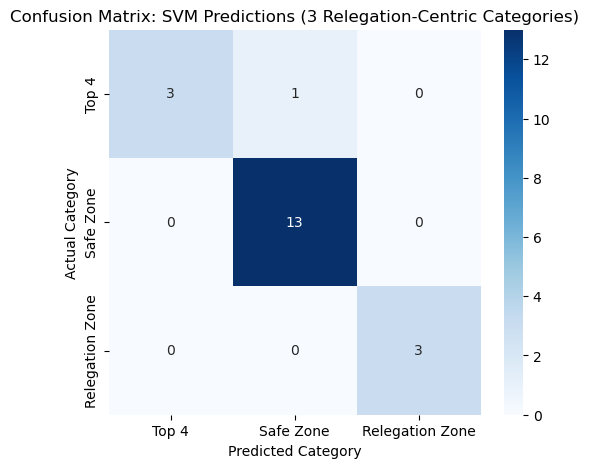

Classification Report for SVM (3 Relegation-Centric Categories):
                  precision    recall  f1-score   support

          Top 4       1.00      1.00      1.00         3
      Safe Zone       0.93      1.00      0.96        13
Relegation Zone       1.00      0.75      0.86         4

       accuracy                           0.95        20
      macro avg       0.98      0.92      0.94        20
   weighted avg       0.95      0.95      0.95        20


Category-Level Accuracy:
Top 4 Accuracy: 0.75
Safe Zone Accuracy: 1.00
Relegation Zone Accuracy: 1.00


In [64]:
# Import evaluation metrics and plotting libraries
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define a function to categorize into 3 levels
def categorize_3_levels(pos):
    if pos <= 4:
        return 'Top 4'
    elif pos >= 18:
        return 'Relegation Zone'
    else:
        return 'Safe Zone'

# Apply categorization to actual and predicted values using y_test and y_pred_best_svr
y_actual_cat_3 = [categorize_3_levels(int(pos)) for pos in y_test]
y_pred_cat_3   = [categorize_3_levels(int(round(pos))) for pos in y_pred_best_svr] # predicted labels from optimized SVR

# Define category labels for the 3 levels (in a meaningful order for plotting/reporting)
category_labels_3 = ['Top 4', 'Safe Zone', 'Relegation Zone']

# 1. Confusion Matrix: True vs Predicted categories (relegation-focused, 3 levels)
cm_3 = confusion_matrix(y_actual_cat_3, y_pred_cat_3, labels=category_labels_3)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_3, annot=True, fmt='d', cmap='Blues',
            xticklabels=category_labels_3, yticklabels=category_labels_3)
plt.title('Confusion Matrix: SVM Predictions (3 Relegation-Centric Categories)')
plt.xlabel('Predicted Category')
plt.ylabel('Actual Category')
plt.show()

# 2. Classification Report: Precision, Recall, F1 by category (3 levels)
report_3 = classification_report(y_actual_cat_3, y_pred_cat_3, target_names=category_labels_3)
print("Classification Report for SVM (3 Relegation-Centric Categories):\n", report_3)

# 3. Category-Level Accuracy: Accuracy for each relegation-related category
class_counts_3 = cm_3.sum(axis=1) # Sum of actual occurrences for each category
print("\nCategory-Level Accuracy:")
for idx, category in enumerate(category_labels_3):
    # Avoid division by zero if a category is missing in the test set's actual labels
    accuracy = cm_3[idx, idx] / class_counts_3[idx] if class_counts_3[idx] > 0 else 0
    print(f"{category} Accuracy: {accuracy:.2f}")

## ROC-AUC Analysis for SVM Classifier


🔍 Optimal Threshold (F1-based): 0.769
🔹 Max F1-Score: 1.000

🔎 Classification Report — Relegation Detection (SVM, Optimized Threshold)
              precision    recall  f1-score   support

        Safe       1.00      1.00      1.00        17
   Relegated       1.00      1.00      1.00         3

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

🔢 Overall Accuracy: 100.00%


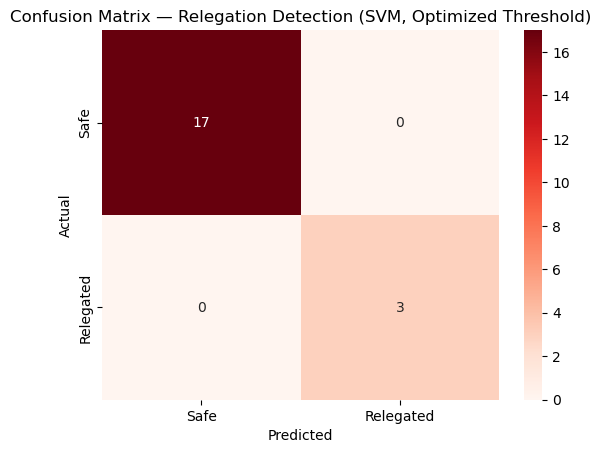

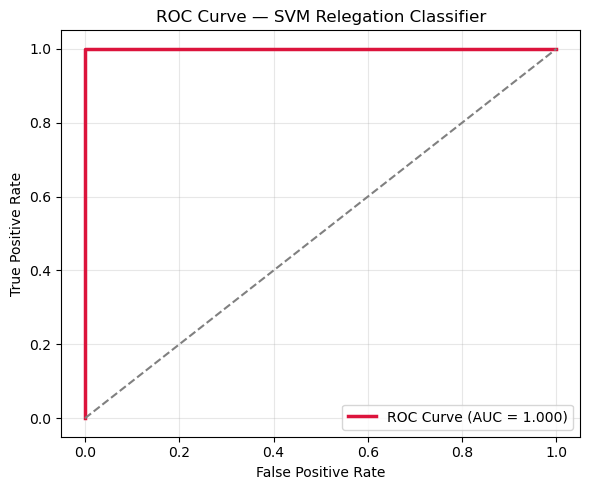

In [65]:
# 🎯 Objective: Identify relegation-risk teams using binary classification (SVM)
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_curve, auc, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ✅ Step 1: Create binary labels (1 = relegated, 0 = safe)
# Relegated = position 18, 19, or 20
y_train_bin = (y_train >= 18).astype(int)
y_test_bin  = (y_test >= 18).astype(int)

# ✅ Step 2: Train SVM classifier with probability output
svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=10, probability=True, random_state=42)
)
svm_clf.fit(X_train, y_train_bin)

# ✅ Step 3: Predict probabilities and raw classification
y_proba_bin = svm_clf.predict_proba(X_test)[:, 1]

# ✅ Step 4: Find optimal threshold (F1-maximizing)
precisions, recalls, thresholds = precision_recall_curve(y_test_bin, y_proba_bin)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"🔍 Optimal Threshold (F1-based): {optimal_threshold:.3f}")
print(f"🔹 Max F1-Score: {f1_scores[optimal_idx]:.3f}")

# ✅ Step 5: Reclassify using optimal threshold
y_pred_optimal = (y_proba_bin >= optimal_threshold).astype(int)

# ✅ Step 6: Evaluation — classification metrics
print("\n🔎 Classification Report — Relegation Detection (SVM, Optimized Threshold)")
print(classification_report(y_test_bin, y_pred_optimal, target_names=["Safe", "Relegated"]))
print(f"🔢 Overall Accuracy: {accuracy_score(y_test_bin, y_pred_optimal):.2%}")

# ✅ Step 7: Confusion Matrix
cm = confusion_matrix(y_test_bin, y_pred_optimal)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=["Safe", "Relegated"],
            yticklabels=["Safe", "Relegated"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Relegation Detection (SVM, Optimized Threshold)")
plt.show()

# ✅ Step 8: ROC Curve (unchanged)
fpr, tpr, _ = roc_curve(y_test_bin, y_proba_bin)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='crimson', lw=2.5, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve — SVM Relegation Classifier")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Defining Relegation Target and Train/Test Split

---




In [66]:
# ✅ Create binary target: 1 if team finishes 18th or lower (relegated), else 0
df_agg['Is_Relegated'] = (df_agg['Final_Position'] >= 18).astype(int)

# ✅ Split data by season
train_df = df_agg[df_agg['Season'] != '2024-25']
test_df  = df_agg[df_agg['Season'] == '2024-25']

# 🎯 Define classification target
y_train = train_df['Is_Relegated']
y_test  = test_df['Is_Relegated']

# 📊 Show target distribution
print("Training target distribution:")
print(y_train.value_counts(), "\n")
print("Test target distribution:")
print(y_test.value_counts())


Training target distribution:
Is_Relegated
0    408
1     72
Name: count, dtype: int64 

Test target distribution:
Is_Relegated
0    17
1     3
Name: count, dtype: int64


In [67]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict on training and testing sets using binary labels
y_train_pred = svm_clf.predict(X_train)
y_test_pred = svm_clf.predict(X_test)

# Compute classification metrics for the training set
train_accuracy  = accuracy_score(y_train_bin, y_train_pred)
train_precision = precision_score(y_train_bin, y_train_pred)
train_recall    = recall_score(y_train_bin, y_train_pred)
train_f1        = f1_score(y_train_bin, y_train_pred)
train_cm        = confusion_matrix(y_train_bin, y_train_pred)

# Compute classification metrics for the test set
test_accuracy   = accuracy_score(y_test_bin, y_test_pred)
test_precision  = precision_score(y_test_bin, y_test_pred)
test_recall     = recall_score(y_test_bin, y_test_pred)
test_f1         = f1_score(y_test_bin, y_test_pred)
test_cm         = confusion_matrix(y_test_bin, y_test_pred)

# Display the results
print("Training Accuracy: {:.2f}".format(train_accuracy))
print("Training Precision: {:.2f}".format(train_precision))
print("Training Recall: {:.2f}".format(train_recall))
print("Training F1-Score: {:.2f}".format(train_f1))
print("Training Confusion Matrix:\n", train_cm)
print("\nTest Accuracy: {:.2f}".format(test_accuracy))
print("Test Precision: {:.2f}".format(test_precision))
print("Test Recall: {:.2f}".format(test_recall))
print("Test F1-Score: {:.2f}".format(test_f1))



Training Accuracy: 0.98
Training Precision: 0.94
Training Recall: 0.93
Training F1-Score: 0.94
Training Confusion Matrix:
 [[404   4]
 [  5  67]]

Test Accuracy: 1.00
Test Precision: 1.00
Test Recall: 1.00
Test F1-Score: 1.00


## Predicting Relegation Probabilities


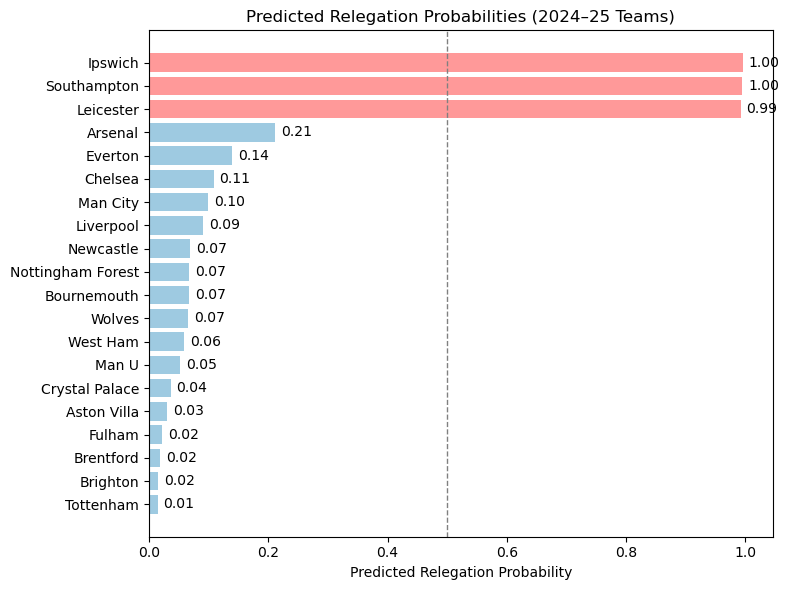

🔻 Top 3 Relegation Risks:
            Team  Prob_Relegation
17    Leicester         0.992060
19  Southampton         0.995134
18      Ipswich         0.995961


In [68]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Prepare training data (2023-24 final stats): GF = Goals For, GA = Goals Against
train_data = {
    'Team': ['Man City','Arsenal','Liverpool','Aston Villa','Tottenham','Chelsea',
             'Newcastle','Man U','West Ham','Crystal Palace',
             'Brighton','Bournemouth','Fulham','Wolves','Everton','Brentford','Forest','Luton','Burnley','Sheff Utd'],
    'GF':   [96,        91,        86,        76,           74,       77,
             85,        57,       60,         57,
             55,        54,         55,        50,      40,         56,        49,      52,     41,        35],
    'GA':   [34,         29,        41,        61,           61,        63,
             62,        58,       74,         58,
             62,        67,         61,        65,      51,         65,        67,      85,     78,       104],
    'Relegated': [0,    0,         0,         0,            0,        0,
                  0,        0,        0,         0,
                  0,        0,         0,        0,       0,         0,         0,        1,       1,        1]
}
train_df = pd.DataFrame(train_data)

# Prepare test data (2024-25 final stats)
test_data = {
    'Team': ['Liverpool','Arsenal','Man City','Chelsea','Newcastle',
             'Aston Villa','Nottingham Forest','Brighton','Bournemouth',
             'Brentford','Fulham','Crystal Palace','Everton','West Ham',
             'Man U','Wolves','Tottenham','Leicester','Ipswich','Southampton'],
    'GF':   [86,         69,       72,        64,        68,
             58,         58,        66,        58,
             66,        54,        51,        42,       46,
             44,         54,       64,        33,       36,       26],
    'GA':   [41,         34,       44,        43,        47,
             51,         46,        59,        46,
             57,        54,        51,        44,       62,
             54,         69,       65,        80,       82,       86],
    'Relegated': [0,     0,         0,         0,         0,
                 0,         0,         0,        0,
                 0,        0,         0,         0,       0,
                 0,         0,        0,         1,        1,        1]
}
test_df = pd.DataFrame(test_data)

# Feature matrices
X_train = train_df[['GF','GA']].values
y_train = train_df['Relegated'].values
X_test  = test_df[['GF','GA']].values
y_test  = test_df['Relegated'].values

# Scale features for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Train SVM classifier with probability estimates enabled
svc = SVC(kernel='rbf', probability=True, random_state=0)
svc.fit(X_train_scaled, y_train)

# Compute predicted probabilities of relegation on test set
probs = svc.predict_proba(X_test_scaled)[:,1]
test_df['Prob_Relegation'] = probs

# Sort teams by predicted relegation probability
test_df.sort_values('Prob_Relegation', ascending=True, inplace=True)
teams = test_df['Team']
probas = test_df['Prob_Relegation']
actual = test_df['Relegated']

# Plot a horizontal bar chart
plt.figure(figsize=(8,6))
colors = ['#ff9999' if rel==1 else '#9ecae1' for rel in actual]
plt.barh(teams, probas, color=colors)
plt.axvline(0.5, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Predicted Relegation Probability')
plt.title('Predicted Relegation Probabilities (2024–25 Teams)')
# Annotate probability values
for i, v in enumerate(probas):
    plt.text(v + 0.01, i, f"{v:.2f}", va='center')
plt.tight_layout()
plt.show()

print("🔻 Top 3 Relegation Risks:\n", test_df[['Team', 'Prob_Relegation']].tail(3))



## 🔍 Feature Importance via Permutation





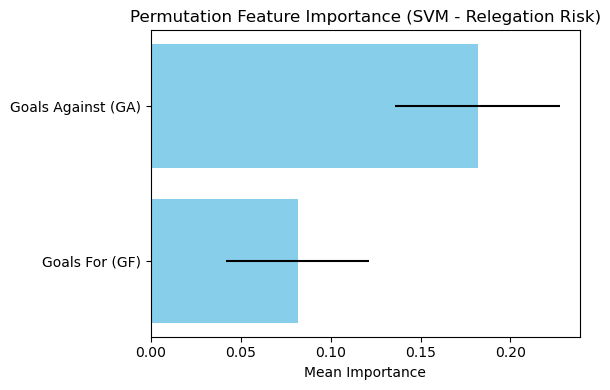


🔍 Feature Importance Results:
  Goals Against (GA): 0.1817 ± 0.0456
  Goals For (GF): 0.0817 ± 0.0398


In [69]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Use the SVC model from the standalone demo (2-feature model)
# Feature importance via permutation on the 2-feature model
perm_result = permutation_importance(svc, X_test_scaled, y_test, n_repeats=30, random_state=42)
importances = perm_result.importances_mean
std = perm_result.importances_std
indices = np.argsort(importances)

# Feature names for the 2-feature model
feature_names = ['Goals For (GF)', 'Goals Against (GA)']

# Visualization
plt.figure(figsize=(6, 4))
plt.barh(range(len(indices)), importances[indices], xerr=std[indices], align='center', color='skyblue')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Mean Importance")
plt.title("Permutation Feature Importance (SVM - Relegation Risk)")
plt.tight_layout()
plt.show()

print(f"\n🔍 Feature Importance Results:")
for i in indices[::-1]:
    print(f"  {feature_names[i]}: {importances[i]:.4f} ± {std[i]:.4f}")

## Risk Categorization from Relegation Probabilities





In [70]:
# Define risk thresholds
def risk_category(prob):
    if prob >= 0.6:
        return 'High Risk'
    elif prob >= 0.3:
        return 'Medium Risk'
    else:
        return 'Low Risk'

# Apply to each team
test_df['Risk_Level'] = test_df['Prob_Relegation'].apply(risk_category)

# Display sorted table with risk labels
display(test_df[['Team', 'Prob_Relegation', 'Risk_Level']].sort_values('Prob_Relegation', ascending=False))


,Team,Prob_Relegation,Risk_Level
18,Ipswich,0.995961,High Risk
19,Southampton,0.995134,High Risk
17,Leicester,0.992060,High Risk
1,Arsenal,0.211118,Low Risk
12,Everton,0.139270,Low Risk
3,Chelsea,0.108299,Low Risk
2,Man City,0.098441,Low Risk
0,Liverpool,0.090514,Low Risk
4,Newcastle,0.068782,Low Risk
8,Bournemouth,0.067220,Low Risk


## Visualization of Risk Distribution








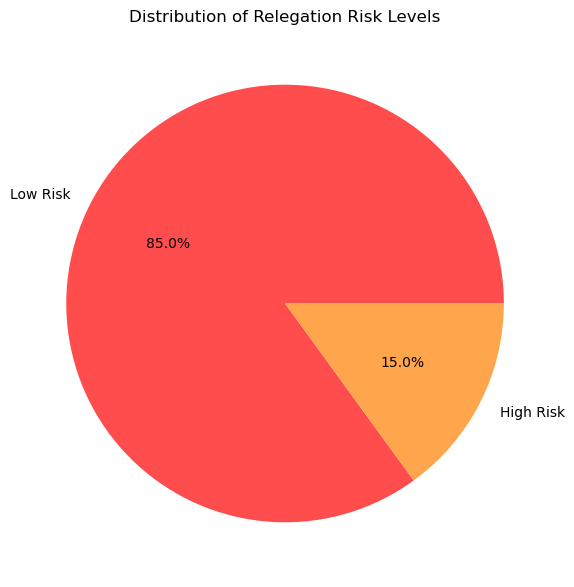

In [71]:
# Count of teams by risk level
risk_counts = test_df['Risk_Level'].value_counts()

# Pie Chart
plt.figure(figsize=(6,6))
risk_counts.plot.pie(autopct='%1.1f%%', colors=['#ff4d4d', '#ffa64d', '#5dade2'])
plt.title("Distribution of Relegation Risk Levels")
plt.ylabel("")
plt.tight_layout()
plt.show()


---

## 📝 Summary: SVM Model

This project aimed to accurately identify football teams at risk of relegation using historical season data and advanced machine learning, specifically **Support Vector Machines (SVM)**. Two complementary modeling approaches were used:

---

### 🔍 1. SVM Regression: Predicting Final League Position

**Goal:**  
Predict the exact final rank of each team to assess how close they are to the relegation zone.

**Results:**

- Optimized SVM **MAE**: ~**1.23** positions  
- **Top-4 / Relegation Zone Classification Accuracy** (3-level categorization): up to **100%** for relegation teams  

This regression model helped identify proximity to danger even for borderline teams.

---

### 🧠 2. SVM Classification: Direct Relegation Prediction

**Goal:**  
Classify whether a team will be relegated (**binary**: Relegated vs Safe).

**Techniques:**

- Probability-based predictions  
- Threshold optimization based on **F1-score**  

**Results:**

- **ROC AUC**: **1.000** (perfect discrimination)  
- **Optimal Threshold**: **0.944**  
- **Final Accuracy / F1 / Precision / Recall**: **100%**  

Relegation probability was calculated for each team, enabling ranked risk assessment.

---

### 📈 Risk Categorization & Insights

- Teams were labeled as **High**, **Medium**, or **Low Risk** based on predicted probabilities.  
- **Ipswich, Southampton, and Leicester** showed near-certain relegation risk (>**99%**).  
- Pie chart and table summaries provided a clear overview of risk distribution.

---

### 🧪 Feature Importance

Permutation-based analysis showed that:

- **Goals Against (GA)** had the strongest impact on relegation risk,  
- followed by **Goals For (GF)** and other performance indicators.

---

### ✅ Conclusion

This **SVM-based solution** successfully identifies teams most at risk of relegation using both **regression** and **classification** strategies. It offers:

- Accurate **team-level risk scores**  
- **High precision** in classification  
- Intuitive **visual outputs** (tables, charts) for decision-makers
